# Weather data analysis

Проведем анализ данных о погоде. Импортируем нужные библиотеки.

In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyrssa as prs

np.random.seed(1)

Считаем данные.

In [9]:
df = pd.read_csv("weather5.csv")
df.head()

,x
0,36.93
1,37.72
2,29.24
3,22.94
4,12.76


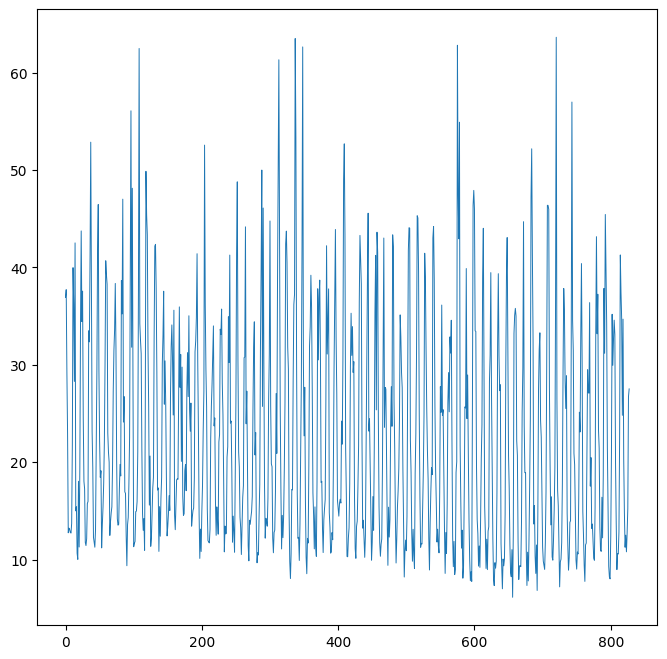

In [13]:
plt.rcParams["figure.figsize"] = (8, 8)
ts = pd.Series(df.x.values)
plt.plot(ts, linewidth=0.7)
plt.show()

Построим базовый SSA, основываясь на предположении о том, что погодные данные имеют период в один год.

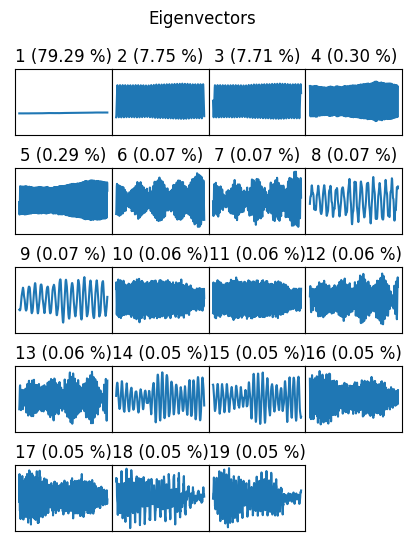

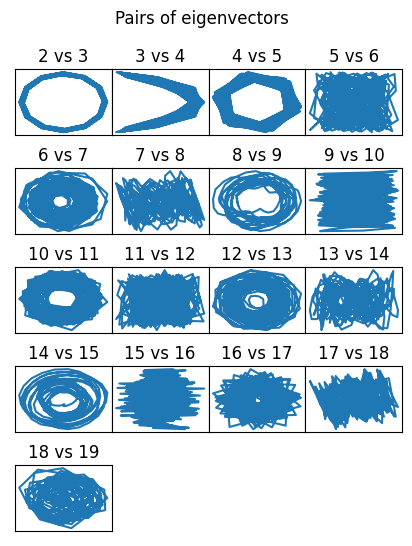

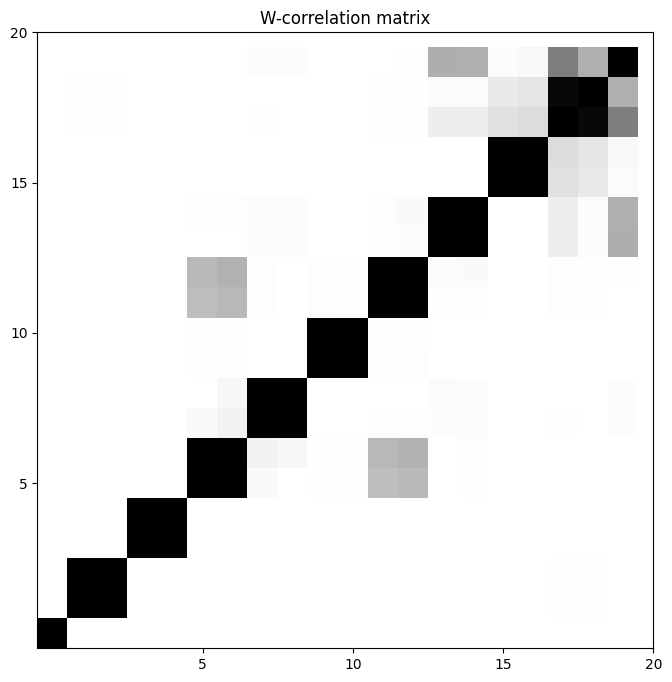

In [42]:
ts_ssa = prs.ssa(ts, L=len(ts) // 2 // 12 * 12, kind="1d-ssa")
prs.plot(ts_ssa, kind="vectors", idx=range(1, 20))
prs.plot(ts_ssa, kind="paired", idx=range(2, 20), contrib=False)
prs.plot(prs.wcor(ts_ssa, groups=range(1, 21)), scales=range(5, 21, 5))

In [62]:
print(prs.parestimate(ts_ssa, group={"Trend": 1, "Seasonality": range(2, 14)}, method="esprit"))

$Trend
   period     rate   |    Mod     Arg  |     Re        Im
      Inf  -0.000178 |  0.99982   0.00 |  0.99982   0.00000

$Seasonality
   period     rate   |    Mod     Arg  |     Re        Im
    7.280   0.000210 |  1.00021   0.86 |  0.65028   0.75997
   -7.280   0.000210 |  1.00021  -0.86 |  0.65028  -0.75997
    5.993   0.000178 |  1.00018   1.05 |  0.49909   0.86676
   -5.993   0.000178 |  1.00018  -1.05 |  0.49909  -0.86676
   11.997   0.000149 |  1.00015   0.52 |  0.86609   0.50019
  -11.997   0.000149 |  1.00015  -0.52 |  0.86609  -0.50019
   28.298  -0.000185 |  0.99982   0.22 |  0.97527   0.22018
  -28.298  -0.000185 |  0.99982  -0.22 |  0.97527  -0.22018
    7.943  -0.000917 |  0.99908   0.79 |  0.70249   0.71040
   -7.943  -0.000917 |  0.99908  -0.79 |  0.70249  -0.71040
    4.772  -0.001451 |  0.99855   1.32 |  0.25101   0.96649
   -4.772  -0.001451 |  0.99855  -1.32 |  0.25101  -0.96649




Среди сезонных компонент выделяются периоды 6 и 12 (компоненты 2-3, 4-5), а также 7, 28 и 4.

Исходя из корреляционной матрицы заметно смешивание компонент (5, 6) и (7, 8), (11, 12).

Построим восстановление ряда.

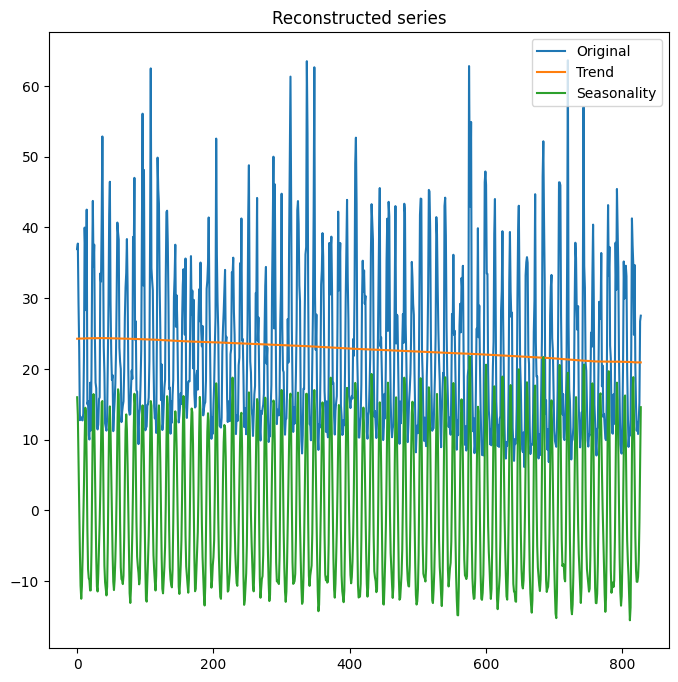

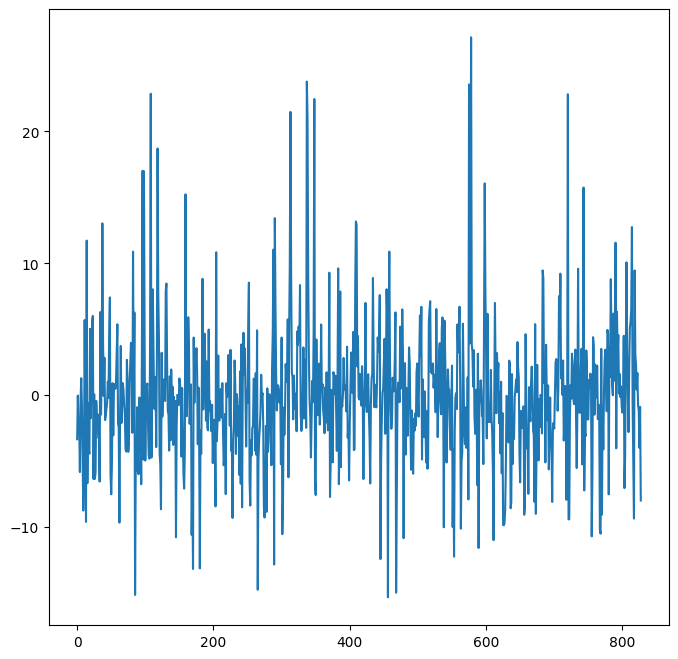

In [78]:
ts_rec = prs.reconstruct(ts_ssa, groups={"Trend": 1, "Seasonality": range(2, 12)})
prs.plot(ts_rec, superpose=True, add_residuals=False)
plt.plot(ts_rec.residuals)
plt.show()

Теперь восстановим сигнал, не разделяя на тренд и сезонность.

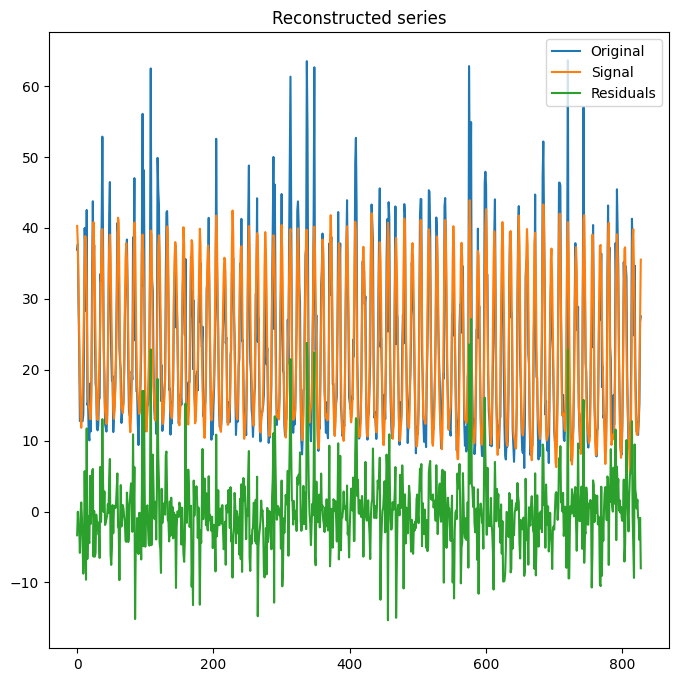

In [75]:
ts_rec = prs.reconstruct(ts_ssa, groups={"Signal": range(1, 12)})
prs.plot(ts_rec, superpose=True)

Построим оценку по MSPE.

In [76]:
ts_mspe = 100 * np.mean( np.sqrt(( (ts - ts_rec.Signal) / ts )**2)) 
print(ts_mspe)

16.634908072873785


Ошибка восстановления составила 16.6%

По графику видно, что восстановление не учитывает некоторые всплески, которые происходят в различные моменты, и все они отнесены к шуму.

Попробуем отрезать часть ряда, например, последние 5 лет, и построить прогноз на основе известных данных, а затем оценить качество прогноза.

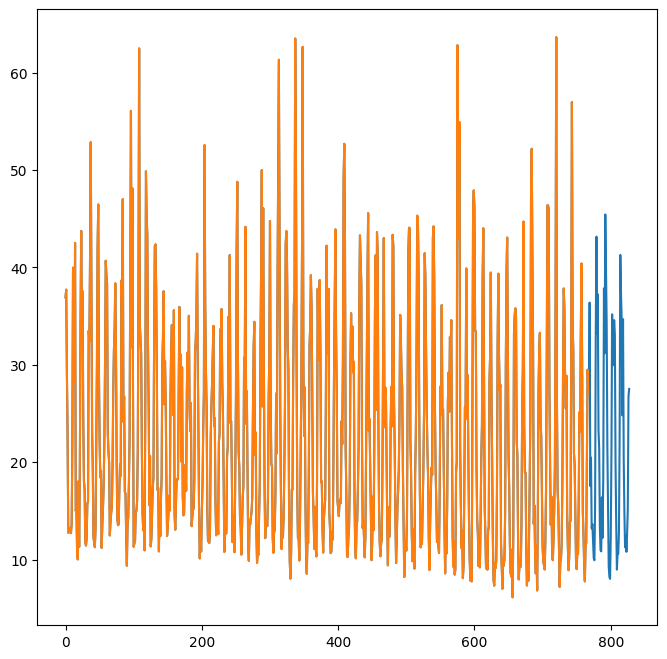

In [88]:
ts_recent = ts[:-(12 * 5)]
ts_actual = ts[-(12 * 5):]
plt.plot(ts)
plt.plot(ts_recent)
plt.show()

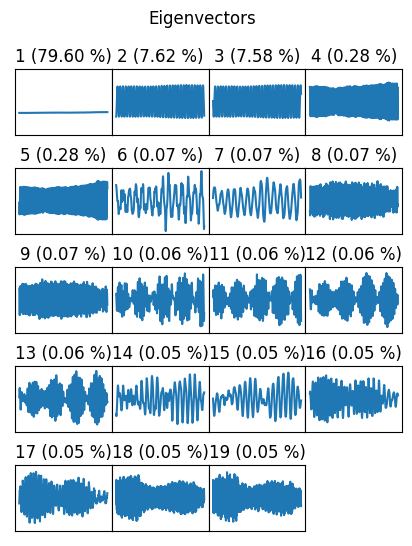

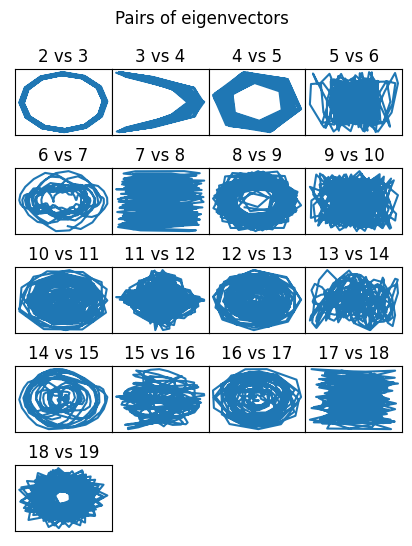

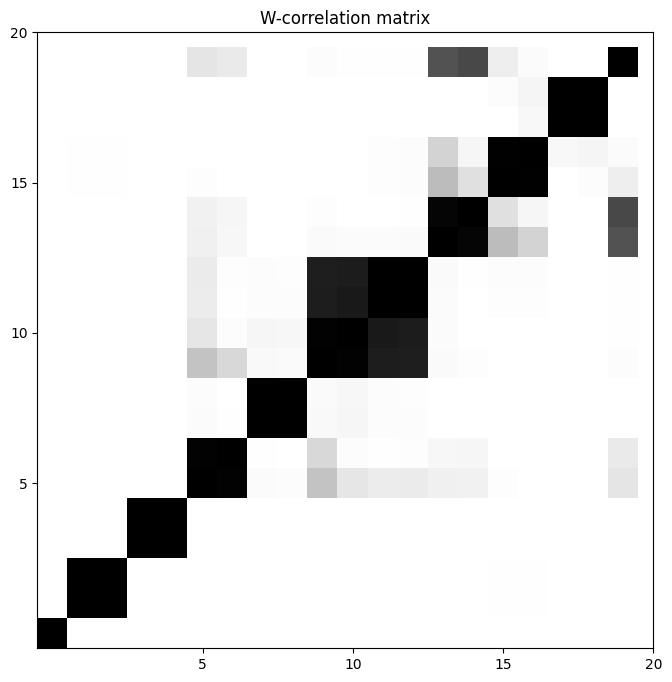

In [83]:
ts_ssa = prs.ssa(ts_recent, L=len(ts_recent) // 2 // 12 * 12, kind="1d-ssa")
prs.plot(ts_ssa, kind="vectors", idx=range(1, 20))
prs.plot(ts_ssa, kind="paired", idx=range(2, 20), contrib=False)
prs.plot(prs.wcor(ts_ssa, groups=range(1, 21)), scales=range(5, 21, 5))

Как видно, в данном случае заметно смешались между собой (10, 11) и (12, 13). Однако, если мы отнесем их к сигналу, необходимости в отделении их друг от друга нет.

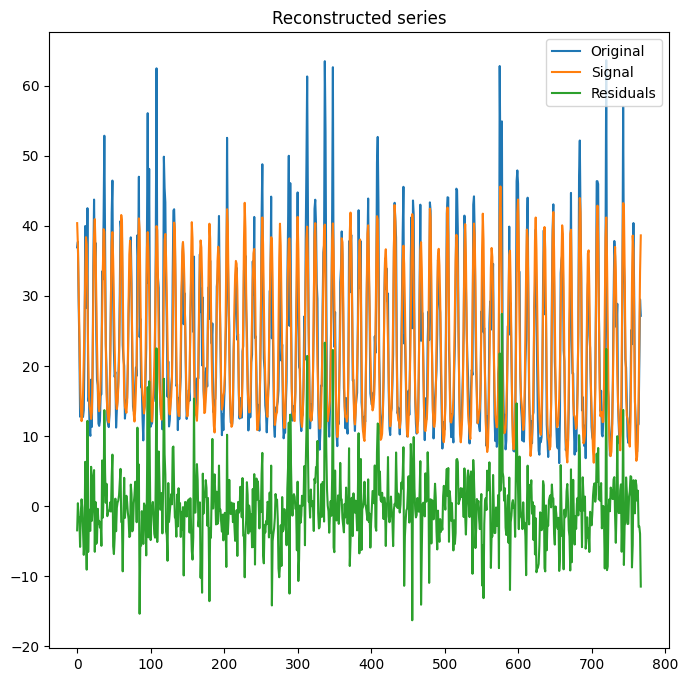

In [87]:
ts_rec = prs.reconstruct(ts_ssa, groups={"Signal": range(1, 14)})
prs.plot(ts_rec, superpose=True)

In [86]:
ts_mspe = 100 * np.mean( np.sqrt(( (ts_recent - ts_rec.Signal) / ts )**2)) 
print(ts_mspe)

16.62997710434034


Ошибка составила 16.6%, как и в прошлом случае.

Попробуем построить рекуррентный прогноз.

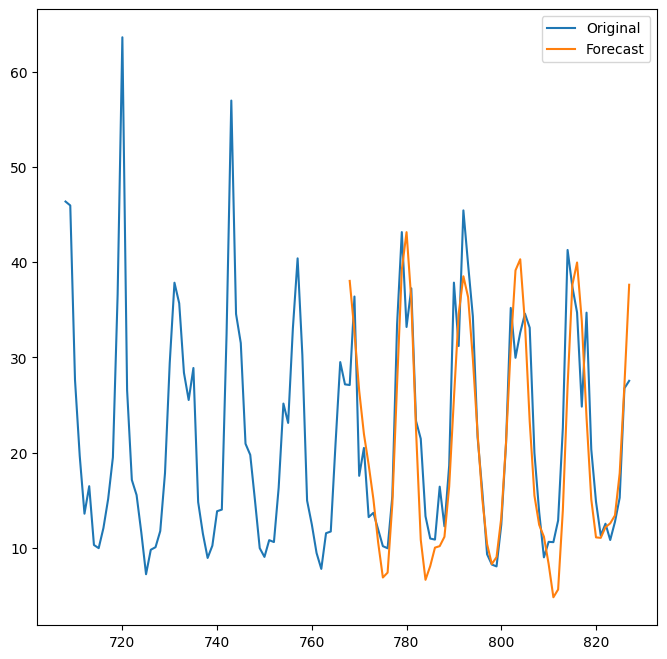

In [120]:
for_length = 12 * 5
ts_rfor = prs.rforecast(ts_ssa, groups={"Signal": range(1, 14)}, length=for_length)

ts_rfor_index = ts_actual.index
ts_rfor.Signal = pd.Series(ts_rfor.Signal, index=ts_rfor_index)

ts_original = pd.concat([ts_recent, ts_actual])
plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_rfor.Signal, label="Forecast")
plt.legend()
plt.show()

Посчитаем MSPE прогноза

In [121]:
rfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_rfor.Signal) / ts_actual_mspe )**2)) 
print(rfor_mspe)

19.445162038182463


Ошибка прогноза составила около 19.4%

Можем взять меньшее число компонент и проверить качество прогноза.

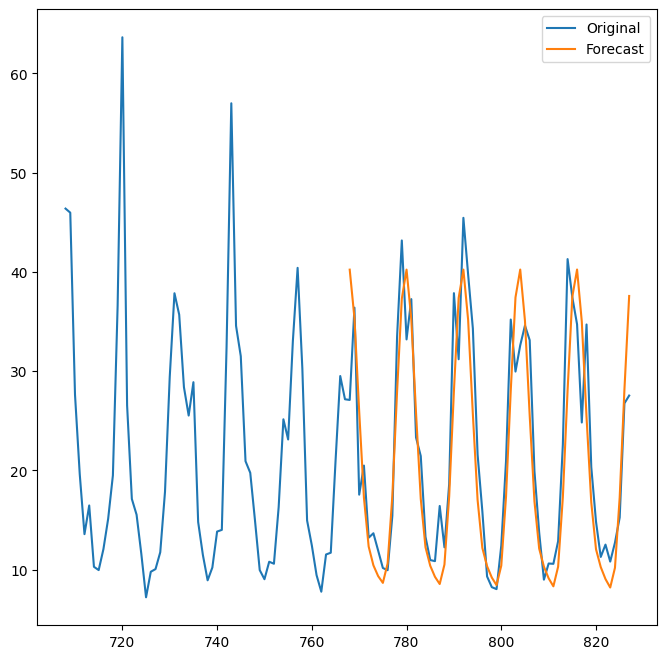

17.590486273057323


In [124]:
for_length = 12 * 5
ts_rfor = prs.rforecast(ts_ssa, groups={"Signal": range(1, 6)}, length=for_length)

ts_rfor_index = ts_actual.index
ts_rfor.Signal = pd.Series(ts_rfor.Signal, index=ts_rfor_index)

ts_original = pd.concat([ts_recent, ts_actual])
plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_rfor.Signal, label="Forecast")
plt.legend()
plt.show()

rfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_rfor.Signal) / ts_actual_mspe )**2)) 
print(rfor_mspe)

По первым пяти компонентам удалось добиться снижения ошибки до 17.6%

Построим теперь векторный прогноз.

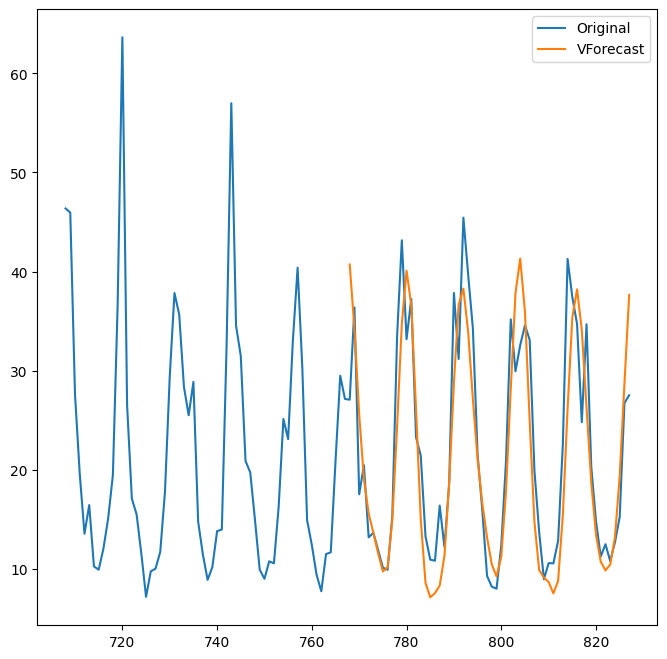

18.0596575984993


In [126]:
for_length = 12 * 5
ts_vfor = prs.vforecast(ts_ssa, groups={"Signal": range(1, 14)}, length=for_length)

ts_vfor_index = ts_actual.index
ts_vfor.Signal = pd.Series(ts_vfor.Signal, index=ts_vfor_index)

plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_vfor.Signal, label="VForecast")
plt.legend()
plt.show()


vfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_vfor.Signal) / ts_actual_mspe )**2)) 
print(vfor_mspe)

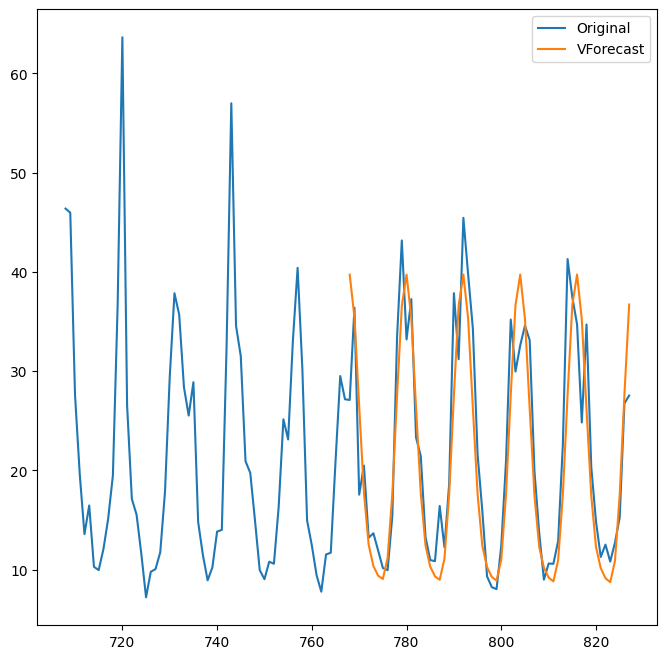

16.6917179230738


In [127]:
for_length = 12 * 5
ts_vfor = prs.vforecast(ts_ssa, groups={"Signal": range(1, 6)}, length=for_length)

ts_vfor_index = ts_actual.index
ts_vfor.Signal = pd.Series(ts_vfor.Signal, index=ts_vfor_index)

plt.plot(ts_original[-(12 * 10):], label="Original")
plt.plot(ts_vfor.Signal, label="VForecast")
plt.legend()
plt.show()


vfor_mspe = 100 * np.mean( np.sqrt(( (ts_actual - ts_vfor.Signal) / ts_actual_mspe )**2)) 
print(vfor_mspe)

При использовании векторного прогноза получили 18 и 16.7% ошибки соответственно. Второе значение оказалось достаточно близким к тому, которое получалось при реконструкции исходного ряда по 14 компонентам.